In [1]:
! pip install pykrx
! pip install pydot


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pykrx import stock
from pykrx import bond
from sklearn.preprocessing import MinMaxScaler


In [3]:
df_samsung = stock.get_market_ohlcv("20180101", "20230831", "005930")
df_samsung

,시가,고가,저가,종가,거래량,등락률
날짜,,,,,,
2018-01-02,51380,51400,50780,51020,169485,0.117739
2018-01-03,52540,52560,51420,51620,200270,1.176009
2018-01-04,52120,52180,50640,51080,233909,-1.046106
2018-01-05,51300,52120,51200,52120,189623,2.036022
2018-01-08,52400,52520,51500,52020,167673,-0.191865
...,...,...,...,...,...,...
2023-08-25,67100,67400,66900,67100,7032462,-1.612903
2023-08-28,66800,67000,66500,66800,5824628,-0.447094
2023-08-29,66900,67200,66600,66800,9114352,0.000000


<Axes: title={'center': 'samsung close price'}, xlabel='날짜'>

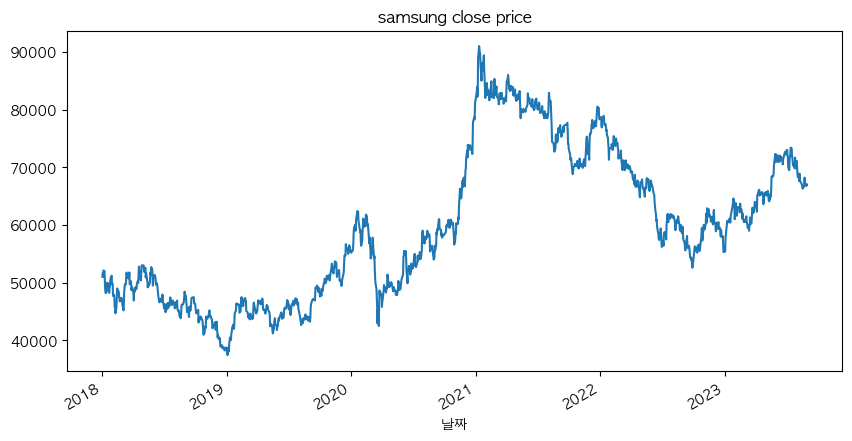

In [4]:
plt.figure(figsize=(10, 5))
plt.title('samsung close price')
df_samsung['종가'].plot()

In [5]:
df_samsung.sort_index(ascending=False).reset_index(drop=True)

scaler = MinMaxScaler()
scale_cols = ['시가', '고가', '저가', '종가', '거래량']
df_samsung_scaled = scaler.fit_transform(df_samsung[scale_cols])
df_samsung_scaled = pd.DataFrame(df_samsung_scaled)
df_samsung_scaled.columns = scale_cols

df_samsung_scaled

,시가,고가,저가,종가,거래량
0,0.568992,0.530992,0.567374,0.253408,0.001877
1,0.581838,0.542975,0.574525,0.264613,0.002218
2,0.577187,0.539050,0.565810,0.254528,0.002590
3,0.568106,0.538430,0.572067,0.273950,0.002100
4,0.580288,0.542562,0.575419,0.272082,0.001857
...,...,...,...,...,...
1393,0.743079,0.696281,0.747486,0.553688,0.077874
1394,0.739756,0.692149,0.743017,0.548086,0.064499
1395,0.740864,0.694215,0.744134,0.548086,0.100927
1396,0.745293,0.699380,0.749721,0.553688,0.101668


In [6]:
df_samsung_scaled['날짜'] = df_samsung.index
df_samsung_scaled

,시가,고가,저가,종가,거래량,날짜
0,0.568992,0.530992,0.567374,0.253408,0.001877,2018-01-02
1,0.581838,0.542975,0.574525,0.264613,0.002218,2018-01-03
2,0.577187,0.539050,0.565810,0.254528,0.002590,2018-01-04
3,0.568106,0.538430,0.572067,0.273950,0.002100,2018-01-05
4,0.580288,0.542562,0.575419,0.272082,0.001857,2018-01-08
...,...,...,...,...,...,...
1393,0.743079,0.696281,0.747486,0.553688,0.077874,2023-08-25
1394,0.739756,0.692149,0.743017,0.548086,0.064499,2023-08-28
1395,0.740864,0.694215,0.744134,0.548086,0.100927,2023-08-29
1396,0.745293,0.699380,0.749721,0.553688,0.101668,2023-08-30


In [7]:
test_size = 1128-790    # 30% test set
window_size = 10
train = df_samsung_scaled[:-test_size]
test = df_samsung_scaled[-test_size:]

train = train.iloc[:,:5]
test = test.iloc[:,:5]

In [8]:
def make_dataset(data, label, window_size=10):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [9]:
feature_cols = ['시가', '고가', '저가', '거래량']
label_cols = ['종가']

train_feature = train[feature_cols]
train_label = train[label_cols]
test_feature = test[feature_cols]
test_label = test[label_cols]
# train dataset
train_feature, train_label = make_dataset(train_feature, train_label, 10)

# train, validation set 생성
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)

x_train.shape, x_valid.shape

# test dataset (실제 예측 해볼 데이터)
test_feature, test_label = make_dataset(test_feature, test_label, 10)
test_feature.shape, test_label.shape

((328, 10, 4), (328, 1))

In [10]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(64, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )
model.add(Dense(128, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='relu'))

In [11]:
! pip install pydot

import tensorflow as tf
from tensorflow.keras.utils import plot_model
tf.keras.utils.plot_model(model, "lstm.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [12]:
import os

model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)

model_path = 'model'
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, epochs=200, batch_size=16,
                    validation_data=(x_valid, y_valid), callbacks=[early_stop, checkpoint])


Epoch 1/200
32/53 [=================>............] - ETA: 0s - loss: 0.2211 
Epoch 1: val_loss improved from inf to 0.24354, saving model to model/tmp_checkpoint.h5
53/53 [==============================] - 1s 4ms/step - loss: 0.2229 - val_loss: 0.2435
Epoch 2/200
37/53 [===================>..........] - ETA: 0s - loss: 0.2292
Epoch 2: val_loss did not improve from 0.24354
53/53 [==============================] - 0s 2ms/step - loss: 0.2229 - val_loss: 0.2435
Epoch 3/200
34/53 [==================>...........] - ETA: 0s - loss: 0.2150

/Users/brianmg/.pyenv/versions/miniforge3-4.9.2/envs/qbz-env/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 3: val_loss did not improve from 0.24354
53/53 [==============================] - 0s 2ms/step - loss: 0.2229 - val_loss: 0.2435
Epoch 4/200
34/53 [==================>...........] - ETA: 0s - loss: 0.2207
Epoch 4: val_loss did not improve from 0.24354
53/53 [==============================] - 0s 2ms/step - loss: 0.2229 - val_loss: 0.2435
Epoch 5/200
34/53 [==================>...........] - ETA: 0s - loss: 0.2243
Epoch 5: val_loss did not improve from 0.24354
53/53 [==============================] - 0s 2ms/step - loss: 0.2229 - val_loss: 0.2435
Epoch 6/200
34/53 [==================>...........] - ETA: 0s - loss: 0.2147
Epoch 6: val_loss did not improve from 0.24354
53/53 [==============================] - 0s 2ms/step - loss: 0.2229 - val_loss: 0.2435


In [13]:
# 모델을 사용하여 예측 수행
y_pred = model.predict(x_valid)

# MSE 및 MAE 계산
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_valid, y_pred)
mae = mean_absolute_error(y_valid, y_pred)

# 예측값과 실제값의 범위 계산
y_range = y_valid.max() - y_valid.min()

# MSE와 MAE를 백분율로 변환
mse_percentage = (mse / y_range) * 100
mae_percentage = (mae / y_range) * 100

print('RSI X')
print(f'Mean Squared Error (MSE) Percentage: {mse_percentage:.2f}%')
print(f'Mean Absolute Error (MAE) Percentage: {mae_percentage:.2f}%')


7/7 [==============================] - 0s 909us/step
RSI X
Mean Squared Error (MSE) Percentage: 24.96%
Mean Absolute Error (MAE) Percentage: 42.13%


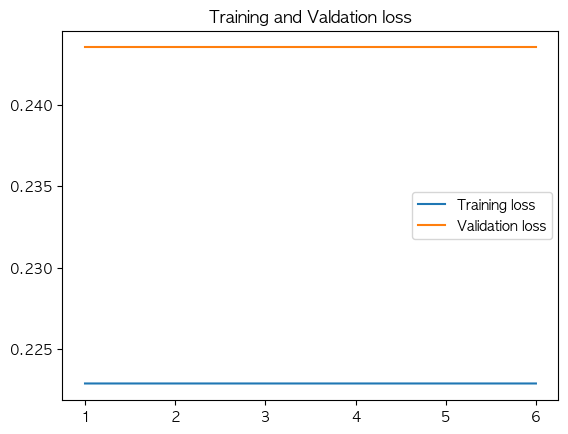

In [14]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Valdation loss')
plt.legend()
plt.show()  

In [15]:
model.load_weights(filename)
pred = model.predict(test_feature)

pred.shape

11/11 [==============================] - 0s 751us/step


(328, 1)

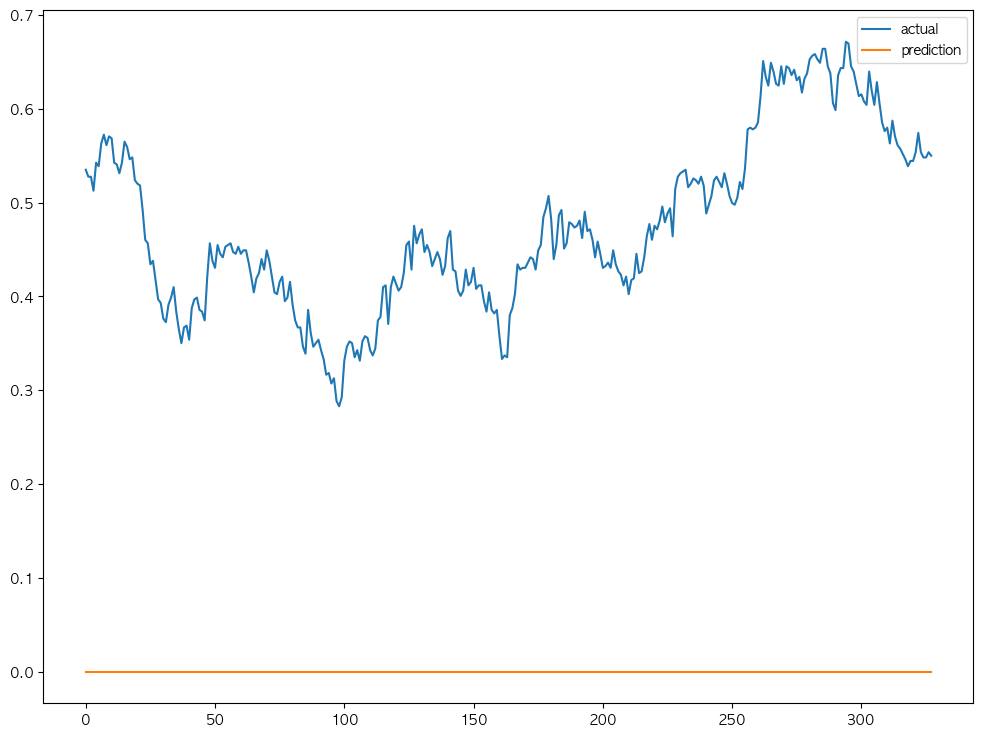

In [16]:
plt.figure(figsize=(12, 9))
plt.plot(test_label, label = 'actual')
plt.plot(pred, label = 'prediction')

# plt.scatter(range(len(test_label)), pred, label='predicted', color='red')

plt.legend()
plt.show()

In [17]:
! pip install plotly
! pip install ipykernel
! pip install --upgrade nbformat


In [18]:
import plotly.graph_objects as go
import plotly.graph_objects as go 
import plotly.subplots as ms 
import plotly.express as px

U = np.where(df_samsung['종가'].diff(1) > 0, df_samsung['종가'].diff(1), 0) 
D = np.where(df_samsung['종가'].diff(1) < 0, df_samsung['종가'].diff(1) *(-1), 0) 
AU = pd.DataFrame(U, index=df_samsung.index).rolling(window=14).mean() 
AD = pd.DataFrame(D, index=df_samsung.index).rolling(window=14).mean() 
RSI = AU / (AD+AU) *100 
df_samsung['RSI'] = RSI
df_samsung['RSI_signal'] = df_samsung["RSI"].rolling(6).mean()

#RSI 추가하기
RSI = go.Scatter(x=df_samsung.index, y=df_samsung['RSI'], line=dict(color='red', width=2), name='RSI', legendgroup='group5', legendgrouptitle_text='RSI')

In [19]:
from plotly.subplots import make_subplots

#과매수매도구간 데이터 추가 (선으로 표현하기 위하여)
df_samsung['과매수구간'] = 70
df_samsung['과매도구간'] = 30

#그래프 객체 넣기
fig = make_subplots(specs=[[{"secondary_y": True}]])

# creating first plot
fig.add_trace(
    go.Scatter(x=df_samsung.index, y=df_samsung['RSI'], name='df_samsung RSI'),
    secondary_y=False,
)   

# creating next plot
fig.add_trace(
    go.Scatter(x=df_samsung.index, y=df_samsung['RSI_signal'], name='df_samsung RSI_signal') , 
   
    secondary_y=True,
)

# creating next plot
fig.add_trace(
    go.Scatter(x=df_samsung.index, y=df_samsung['과매수구간'], name='과매수구간') , 
   
    secondary_y=True,
)

# creating next plot
fig.add_trace(
    go.Scatter(x=df_samsung.index, y=df_samsung['과매도구간'], name='과매도구간') , 
   
    secondary_y=True,
)
fig.update_layout(title_text="df_samsung RSI", title_x=0.5)
fig.show()

In [20]:
df_samsung


,시가,고가,저가,종가,거래량,등락률,RSI,RSI_signal,과매수구간,과매도구간
날짜,,,,,,,,,,
2018-01-02,51380,51400,50780,51020,169485,0.117739,NaN,NaN,70,30
2018-01-03,52540,52560,51420,51620,200270,1.176009,NaN,NaN,70,30
2018-01-04,52120,52180,50640,51080,233909,-1.046106,NaN,NaN,70,30
2018-01-05,51300,52120,51200,52120,189623,2.036022,NaN,NaN,70,30
2018-01-08,52400,52520,51500,52020,167673,-0.191865,NaN,NaN,70,30
...,...,...,...,...,...,...,...,...,...,...
2023-08-25,67100,67400,66900,67100,7032462,-1.612903,42.500000,33.835133,70,30
2023-08-28,66800,67000,66500,66800,5824628,-0.447094,39.506173,35.705691,70,30
2023-08-29,66900,67200,66600,66800,9114352,0.000000,44.444444,37.616644,70,30


In [21]:
aa = abs(df_samsung['종가']-df_samsung['종가'].shift(1))
bb = aa/df_samsung['종가']*100
df_samsung['CLOSE_PRIVATE'] = bb

In [22]:
df_samsung.head(20)


,시가,고가,저가,종가,거래량,등락률,RSI,RSI_signal,과매수구간,과매도구간,CLOSE_PRIVATE
날짜,,,,,,,,,,,
2018-01-02,51380,51400,50780,51020,169485,0.117739,NaN,NaN,70,30,NaN
2018-01-03,52540,52560,51420,51620,200270,1.176009,NaN,NaN,70,30,1.162340
2018-01-04,52120,52180,50640,51080,233909,-1.046106,NaN,NaN,70,30,1.057165
2018-01-05,51300,52120,51200,52120,189623,2.036022,NaN,NaN,70,30,1.995395
2018-01-08,52400,52520,51500,52020,167673,-0.191865,NaN,NaN,70,30,0.192234
2018-01-09,51460,51720,49980,50400,360272,-3.114187,NaN,NaN,70,30,3.214286
2018-01-10,50500,50520,48640,48840,371336,-3.095238,NaN,NaN,70,30,3.194103
2018-01-11,48200,49260,48020,48240,502476,-1.228501,NaN,NaN,70,30,1.243781
2018-01-12,48240,48480,46760,48200,545409,-0.082919,NaN,NaN,70,30,0.082988


In [23]:
df_samsung = df_samsung.iloc[18:,:]
df_samsung

,시가,고가,저가,종가,거래량,등락률,RSI,RSI_signal,과매수구간,과매도구간,CLOSE_PRIVATE
날짜,,,,,,,,,,,
2018-01-26,50500,50780,49840,50780,207002,1.034620,44.083969,40.287146,70,30,1.024025
2018-01-29,51200,51480,50900,51220,236776,0.866483,54.408602,42.571876,70,30,0.859039
2018-01-30,50440,50640,49780,49800,245691,-2.772355,55.240175,45.712036,70,30,2.851406
2018-01-31,50020,54140,49600,49900,1293626,0.200803,59.584296,49.254390,70,30,0.200401
2018-02-01,50620,50960,49720,49820,552189,-0.160321,59.310345,52.230476,70,30,0.160578
...,...,...,...,...,...,...,...,...,...,...,...
2023-08-25,67100,67400,66900,67100,7032462,-1.612903,42.500000,33.835133,70,30,1.639344
2023-08-28,66800,67000,66500,66800,5824628,-0.447094,39.506173,35.705691,70,30,0.449102
2023-08-29,66900,67200,66600,66800,9114352,0.000000,44.444444,37.616644,70,30,0.000000


In [24]:
from sklearn.preprocessing import MinMaxScaler

df_samsung.sort_index(ascending=False).reset_index(drop=True)

scaler = MinMaxScaler()
scale_cols = ['시가', '고가', '저가', '종가', '거래량','RSI','CLOSE_PRIVATE']
df_samsung_scaled = scaler.fit_transform(df_samsung[scale_cols])
df_samsung_scaled = pd.DataFrame(df_samsung_scaled)
df_samsung_scaled.columns = scale_cols

df_samsung_scaled

,시가,고가,저가,종가,거래량,RSI,CLOSE_PRIVATE
0,0.559247,0.524587,0.556872,0.248926,0.002292,0.472929,0.108040
1,0.566999,0.531818,0.568715,0.257143,0.002622,0.591445,0.090633
2,0.558583,0.523140,0.556201,0.230626,0.002721,0.600991,0.300839
3,0.553931,0.559298,0.554190,0.232493,0.014325,0.650857,0.021143
4,0.560576,0.526446,0.555531,0.230999,0.006115,0.647713,0.016942
...,...,...,...,...,...,...,...
1375,0.743079,0.696281,0.747486,0.553688,0.077874,0.454746,0.172960
1376,0.739756,0.692149,0.743017,0.548086,0.064499,0.420380,0.047383
1377,0.740864,0.694215,0.744134,0.548086,0.100927,0.477066,0.000000
1378,0.745293,0.699380,0.749721,0.553688,0.101668,0.374208,0.047171


In [25]:
df_samsung_scaled['날짜'] = df_samsung.index
df_samsung_scaled.head(5)


,시가,고가,저가,종가,거래량,RSI,CLOSE_PRIVATE,날짜
0,0.559247,0.524587,0.556872,0.248926,0.002292,0.472929,0.108040,2018-01-26
1,0.566999,0.531818,0.568715,0.257143,0.002622,0.591445,0.090633,2018-01-29
2,0.558583,0.523140,0.556201,0.230626,0.002721,0.600991,0.300839,2018-01-30
3,0.553931,0.559298,0.554190,0.232493,0.014325,0.650857,0.021143,2018-01-31
4,0.560576,0.526446,0.555531,0.230999,0.006115,0.647713,0.016942,2018-02-01


In [26]:
test_size = 1110-777    # 30% test set
window_size = 10
train = df_samsung_scaled[:-test_size]
test = df_samsung_scaled[-test_size:]

train = train.iloc[:,:7]
test = test.iloc[:,:7]

feature_cols = ['시가', '고가', '저가', '거래량', 'RSI', 'CLOSE_PRIVATE']
label_cols = ['종가']

train_feature = train[feature_cols]
train_label = train[label_cols]
test_feature = test[feature_cols]
test_label = test[label_cols]
# train dataset
train_feature, train_label = make_dataset(train_feature, train_label, 10)

# train, validation set 생성
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)

x_train.shape, x_valid.shape

# test dataset (실제 예측 해볼 데이터)
test_feature, test_label = make_dataset(test_feature, test_label, 10)
test_feature.shape, test_label.shape

((323, 10, 6), (323, 1))

In [27]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(64, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )
model.add(Dense(128, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='relu'))

import tensorflow as tf
# from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(model, "lstm.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [28]:
import os

model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)

model_path = 'model'
filename = os.path.join(model_path, 'tmp_checkpoint2.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, epochs=200, batch_size=32,
                    validation_data=(x_valid, y_valid), callbacks=[early_stop, checkpoint])




Epoch 1/200
 1/26 [>.............................] - ETA: 9s - loss: 0.2170
Epoch 1: val_loss improved from inf to 0.23283, saving model to model/tmp_checkpoint2.h5
26/26 [==============================] - 1s 9ms/step - loss: 0.2298 - val_loss: 0.2328
Epoch 2/200
 1/26 [>.............................] - ETA: 0s - loss: 0.1357
Epoch 2: val_loss did not improve from 0.23283
26/26 [==============================] - 0s 2ms/step - loss: 0.2298 - val_loss: 0.2328
Epoch 3/200
 1/26 [>.............................] - ETA: 0s - loss: 0.1693
Epoch 3: val_loss did not improve from 0.23283
26/26 [==============================] - 0s 2ms/step - loss: 0.2298 - val_loss: 0.2328
Epoch 4/200
 1/26 [>.............................] - ETA: 0s - loss: 0.2357
Epoch 4: val_loss did not improve from 0.23283
26/26 [==============================] - 0s 2ms/step - loss: 0.2298 - val_loss: 0.2328
Epoch 5/200
 1/26 [>.............................] - ETA: 0s - loss: 0.1551

/Users/brianmg/.pyenv/versions/miniforge3-4.9.2/envs/qbz-env/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.




Epoch 5: val_loss did not improve from 0.23283
26/26 [==============================] - 0s 2ms/step - loss: 0.2298 - val_loss: 0.2328
Epoch 6/200
 1/26 [>.............................] - ETA: 0s - loss: 0.3225
Epoch 6: val_loss did not improve from 0.23283
26/26 [==============================] - 0s 2ms/step - loss: 0.2298 - val_loss: 0.2328


In [29]:
# 모델을 사용하여 예측 수행
y_pred = model.predict(x_valid)

# MSE 및 MAE 계산
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_valid, y_pred)
mae = mean_absolute_error(y_valid, y_pred)

# 예측값과 실제값의 범위 계산
y_range = y_valid.max() - y_valid.min()

# MSE와 MAE를 백분율로 변환
mse_percentage = (mse / y_range) * 100
mae_percentage = (mae / y_range) * 100

print('RSI O')

print(f'Mean Squared Error (MSE) Percentage: {mse_percentage:.2f}%')
print(f'Mean Absolute Error (MAE) Percentage: {mae_percentage:.2f}%')


7/7 [==============================] - 0s 998us/step
RSI O
Mean Squared Error (MSE) Percentage: 24.74%
Mean Absolute Error (MAE) Percentage: 43.01%


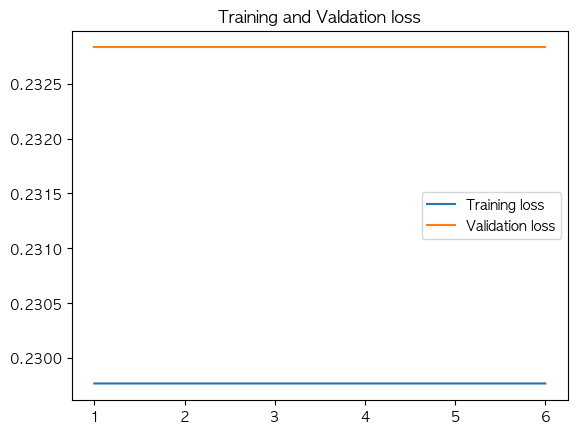

In [30]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Valdation loss')
plt.legend()
plt.show()  

In [31]:
model.load_weights(filename)
pred = model.predict(test_feature)

pred.shape

11/11 [==============================] - 0s 775us/step


(323, 1)

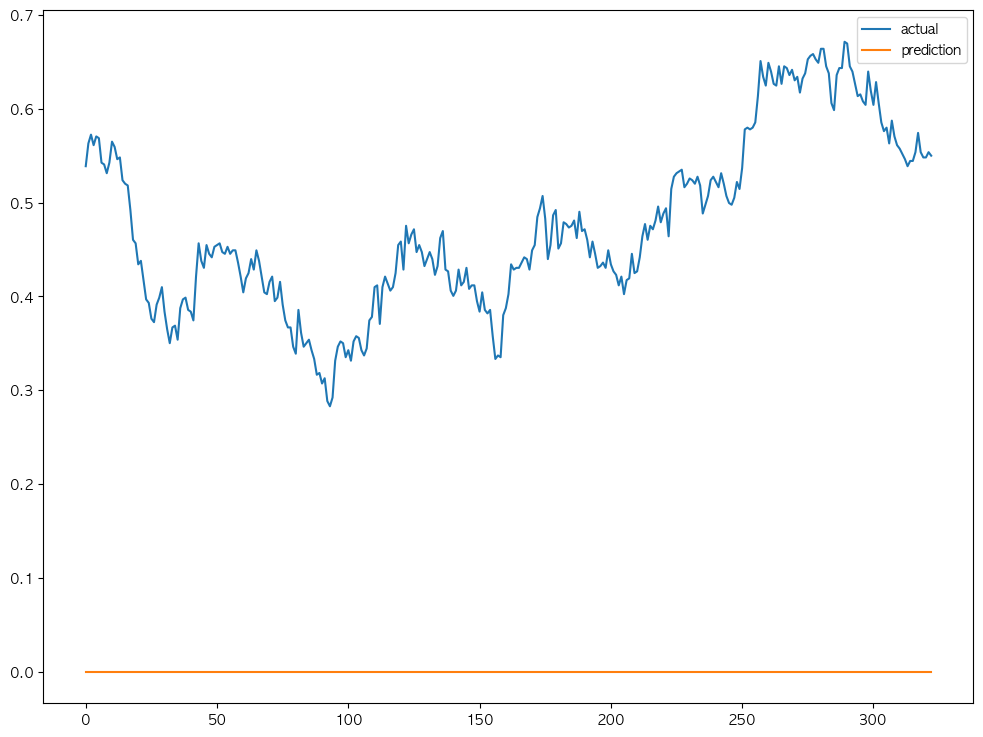

In [32]:
plt.figure(figsize=(12, 9))
plt.plot(test_label, label = 'actual')
plt.plot(pred, label = 'prediction')
plt.legend()
plt.show()


In [33]:
!pip3 install backtesting


In [34]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.test import SMA



/Users/brianmg/.pyenv/versions/miniforge3-4.9.2/envs/qbz-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

/Users/brianmg/.pyenv/versions/miniforge3-4.9.2/envs/qbz-env/lib/python3.11/site-packages/backtesting/test/__init__.py:8: FutureWarning:

The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.

/Users/brianmg/.pyenv/versions/miniforge3-4.9.2/envs/qbz-env/lib/python3.11/site-packages/backtesting/test/__init__.py:8: FutureWarning:

The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safel

In [35]:
df_samsung["target"] = df_samsung["종가"].shift(-1)  # 종가의 다음 날 가격을 "target" 열로 설정
df_samsung["target"] = (df_samsung["target"] > df_samsung["종가"]).astype(int)  # 조건에 따라 이진값으로 변환


/var/folders/tb/v595q0nx3k5bqkrhqq7z9syc0000gn/T/ipykernel_81353/2587542215.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/tb/v595q0nx3k5bqkrhqq7z9syc0000gn/T/ipykernel_81353/2587542215.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [36]:
aa = df_samsung['종가']-df_samsung['종가'].shift(1)
aa>0
df_samsung["target"] = df_samsung["target"].astype(int)
df_samsung_bak = df_samsung.loc[:,['시가','고가','저가','종가','거래량','RSI','CLOSE_PRIVATE','target']]
# df_samsung_bak      
df_samsung_bak_eng = df_samsung_bak.rename(columns={'시가':'Open', '고가':'High', '저가':'Low', '종가':'Close'})
df_samsung_bak_eng

/var/folders/tb/v595q0nx3k5bqkrhqq7z9syc0000gn/T/ipykernel_81353/2822999976.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Open,High,Low,Close,거래량,RSI,CLOSE_PRIVATE,target
날짜,,,,,,,,
2018-01-26,50500,50780,49840,50780,207002,44.083969,1.024025,1
2018-01-29,51200,51480,50900,51220,236776,54.408602,0.859039,0
2018-01-30,50440,50640,49780,49800,245691,55.240175,2.851406,1
2018-01-31,50020,54140,49600,49900,1293626,59.584296,0.200401,0
2018-02-01,50620,50960,49720,49820,552189,59.310345,0.160578,0
...,...,...,...,...,...,...,...,...
2023-08-25,67100,67400,66900,67100,7032462,42.500000,1.639344,0
2023-08-28,66800,67000,66500,66800,5824628,39.506173,0.449102,0
2023-08-29,66900,67200,66600,66800,9114352,44.444444,0.000000,1


In [37]:

import talib

df_samsung_bak_eng = df_samsung_bak_eng.copy()
df_samsung_bak_eng['target'] = df_samsung_bak_eng['target'].astype(int)


In [38]:
class SmaCross(Strategy):
    n1 = 5
    n2 = 20
    
    def init(self):
        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)
    
    def next(self):
        if crossover(self.sma1, self.sma2):
            self.position.close()
            self.buy()
            # self.sell()

        elif crossover(self.sma2, self.sma1):
            self.position.close()
            self.sell()
            # self.buy()

            

class RSIStrategy(Strategy):
    n1 = 5  # 단기 이동평균 기간
    n2 = 20  # 장기 이동평균 기간
    rsi_period = 14  # RSI 계산 기간
    overbought_threshold = 70  # 매도 시점 (과매수 구간)
    oversold_threshold = 30  # 매수 시점 (과매도 구간)

    def init(self):
        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)
        self.rsi = self.I(RSI, self.data.Close, self.rsi_period)

    def next(self):
        if crossover(self.sma1, self.sma2) and self.rsi < self.oversold_threshold:
            self.position.close()
            self.buy()

        elif crossunder(self.sma1, self.sma2) and self.rsi > self.overbought_threshold:
            self.position.close()
            self.sell()




In [39]:
from backtesting import Backtest

# bt = Backtest(df_samsung_bak_eng, SmaCross, cash=1000000, commission=.002)
bt = Backtest(df_samsung_bak_eng, RSIStrategy, cash=1000000, commission=.002)

stats = bt.run()
stats

RuntimeError: Indicator "RSI(C,14)" errored with exception: 'Scatter' object is not callable